# Space time worm

In [55]:
import os
from pathlib import Path
import json
import geojson
import requests
import math

#import netCDF4 as nc
import xarray as xr
import numpy as np
import pandas as pd
from geojson import Feature, Point, FeatureCollection, MultiPolygon, Polygon, load as geojson_load
from matplotlib import pyplot as plt
import folium

In [64]:
# Variables

# Distance/width of the corridor (total width/total height of bbox = 2*distance)
DIST_CORRIDOR = 60
# Ocean/Weather variables
GFS_VAR_LIST = ['u-component_of_wind_maximum_wind', 'v-component_of_wind_maximum_wind', 'Temperature_surface']
WAVE_VAR_LIST = ['VHM0','VPED','VTPK']
PHYS_VAR_LIST =['so','uo','vo']

# project directory
PROJECT_DIR = '/home/martin/Projekte/MariData/software/space_time_worm/'

# geojson file
ROUTE_FROM_GEOJSON = False
GEOJSON_FILE = 'space_time_worm_{}km.geojson'.format(DIST_CORRIDOR)
# needed if ROUTE_FROM_GEOJSON == False
SCRUBBER_FILE = '/home/martin/Projekte/MariData/data/Buettner/CB_scrubber_parsed.csv'

# netcdf files
DOWNLOAD = False
#NC_SRC_DIR = '{}source_data/17_12_2021_{}km'.format(PROJECT_DIR, DIST_CORRIDOR)
NC_SRC_DIR = '{}source_data/20_01_2022_{}km'.format(PROJECT_DIR, DIST_CORRIDOR)
NC_FILE_REL_COORDS = '{}cmems_cube_{}km_relative_coordinates.nc'.format(PROJECT_DIR, DIST_CORRIDOR)
NC_FILE_GROUPS = '{}cmems_cube_{}km_groups.nc'.format(PROJECT_DIR, DIST_CORRIDOR)


---

## 1 ) Helper functions

In [41]:
# earth radius in km
r = 6371 

# distance between two meridians (1 deg longitude) in km at given latitude
def dist_meridian_km(lat):
    u = 2*np.pi*r
    return np.cos(np.deg2rad(lat)) * u / 360

def dist_lon_deg(d_km, lat):
    return d_km / dist_meridian_km(lat)

def dist_lat_deg(d_km):
    return d_km * 360 / (2*np.pi*r)

def corridor_bbox(p, dist, lat):
    return [p[0]-dist_lon_deg(dist, lat), 
         p[1]-dist_lat_deg(dist),
         p[0]+dist_lon_deg(dist, lat),
         p[1]+dist_lat_deg(dist)]

def bbox_to_polygon(bbox):
    return [[[bbox[0],bbox[1]],[bbox[2],bbox[1]],[bbox[2],bbox[3]],[bbox[0],bbox[3]],[bbox[0],bbox[1]]]]

def polygon_to_bbox(polygon):
    lons = [p[0] for p in polygon]
    lats = [p[1] for p in polygon]
    return [np.min(lons), np.min(lats), np.max(lons), np.max(lats)]

def walk_groups(top):
    yield top.groups.values()
    for value in top.groups.values():
        yield from walktree(value)

In [42]:
#date_to_str = lambda x: x.strftime('%Y-%m-%dT%H:%M:%SZ')
date_to_str = lambda x: x.strftime('%Y-%m-%dT%H:%M')

def build_env_data_url(lon_lo, lon_hi, lat_lo, lat_hi, date_lo, date_hi, 
                       wave_params=WAVE_VAR_LIST, phys_params=PHYS_VAR_LIST,
                       gfs_params=GFS_VAR_LIST, format='netcdf'):
    base_url = 'https://harvester.maridata.dev.52north.org/EnvDataAPI/request_env_data?'
    url = base_url + 'date_lo={}'.format(date_to_str(date_lo))
    url = url + '&date_hi={}'.format(date_to_str(date_hi))
    url = url + '&lat_lo={}'.format(lat_lo)
    url = url + '&lat_hi={}'.format(lat_hi)
    url = url + '&lon_lo={}'.format(lon_lo)
    url = url + '&lon_hi={}'.format(lon_hi)
    for param in wave_params:
        url = url + '&Wave={}'.format(param)
    for param in phys_params:
        url = url + '&Physical={}'.format(param)
    for param in gfs_params:
        url = url + '&GFS={}'.format(param)
    url = url + '&format={}'.format(format)

    return url

In [43]:
def transform_coordinates(dataset, point):
    """Transform coordinates to relative grid starting at (0,0)"""
    round_precision = 6
    dataset = dataset.assign_coords(longitude=lambda dataset: np.round(dataset.longitude - point[0], round_precision))
    dataset = dataset.assign_coords(latitude=lambda dataset: np.round(dataset.latitude - point[1], round_precision))
    #print(dataset)
    return dataset

In [44]:
def save_with_groups(datasets, out, group_base='point'):
    """
    Save xarray datasets to netCDF file adding every dataset as separate group
    :param datasets: list of xarray datasets
    :out: str
        name of output file (absolute path)
    :group_base: str
        base name of the group (number is appended automatically)
    :returns: filename of created file
    """
    if Path(out).exists():
        try:
            os.remove(out)
            print('Removed file {}'.format(out))
        except OSError:
            pass
    
    for idx, dataset in enumerate(datasets):
        if idx == 0:
            dataset.to_netcdf(out, 'w', group='/{}_{:02d}'.format(group_base, idx+1))
        else:
            dataset.to_netcdf(out, 'a', group='/{}_{:02d}'.format(group_base, idx+1))
    
    return out

def save_with_local_grid(datasets, out):
    pass

---

## 2) Create route and bboxes

### 2.1) Define route 

<ol>
  <li>Read example scrubber trajectory data</li>
  <li>Define time series for 2 days with a 3-hour interval</li>
  <li>Extract coordinates for time series from step 2</li>
  <li>Create geojson with time series and coordinates</li>
</ol>

In [45]:
if not ROUTE_FROM_GEOJSON:
    df = pd.read_csv(SCRUBBER_FILE)

In [46]:
if not ROUTE_FROM_GEOJSON:
    times = pd.date_range("2021-04-02 00:00:00", periods=16, freq="3H")
    print(times)

DatetimeIndex(['2021-04-02 00:00:00', '2021-04-02 03:00:00',
               '2021-04-02 06:00:00', '2021-04-02 09:00:00',
               '2021-04-02 12:00:00', '2021-04-02 15:00:00',
               '2021-04-02 18:00:00', '2021-04-02 21:00:00',
               '2021-04-03 00:00:00', '2021-04-03 03:00:00',
               '2021-04-03 06:00:00', '2021-04-03 09:00:00',
               '2021-04-03 12:00:00', '2021-04-03 15:00:00',
               '2021-04-03 18:00:00', '2021-04-03 21:00:00'],
              dtype='datetime64[ns]', freq='3H')


In [47]:
if not ROUTE_FROM_GEOJSON:
    time_filter = [False] * len(df)
    for time in times:
        time_filter = time_filter | (df['Date/Time (UTC)'] >= str(time+pd.Timedelta(-2,'m'))) & (df['Date/Time (UTC)'] <= str(time+pd.Timedelta(2,'m')))

    df_filtered = df[time_filter]
    print(len(df_filtered))

16


In [48]:
if not ROUTE_FROM_GEOJSON:
    points = list(zip(round(df_filtered['Longitude'], 1),round(df_filtered['Latitude'], 1)))
    print(points)

[(-2.0, 45.8), (-2.8, 46.2), (-3.6, 46.6), (-4.3, 47.1), (-5.1, 47.6), (-5.7, 48.1), (-5.7, 48.7), (-4.8, 49.1), (-4.0, 49.4), (-3.2, 49.7), (-2.4, 49.9), (-1.6, 50.0), (-0.4, 50.2), (0.7, 50.4), (1.4, 50.9), (2.1, 51.3)]


In [50]:
if not ROUTE_FROM_GEOJSON:
    point_features = []

    for idx, point in enumerate(points):
        point_features.append(Feature(geometry=Point(point), properties={"time": str(times[idx])}))

    route_geojson = FeatureCollection(point_features)
    print(json.dumps(route_geojson, indent=2))

{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "geometry": {
        "type": "Point",
        "coordinates": [
          -2.0,
          45.8
        ]
      },
      "properties": {
        "time": "2021-04-02 00:00:00"
      }
    },
    {
      "type": "Feature",
      "geometry": {
        "type": "Point",
        "coordinates": [
          -2.8,
          46.2
        ]
      },
      "properties": {
        "time": "2021-04-02 03:00:00"
      }
    },
    {
      "type": "Feature",
      "geometry": {
        "type": "Point",
        "coordinates": [
          -3.6,
          46.6
        ]
      },
      "properties": {
        "time": "2021-04-02 06:00:00"
      }
    },
    {
      "type": "Feature",
      "geometry": {
        "type": "Point",
        "coordinates": [
          -4.3,
          47.1
        ]
      },
      "properties": {
        "time": "2021-04-02 09:00:00"
      }
    },
    {
      "type": "Feature",
      "geometry"

### 2.2) Define bboxes

<ol>
  <li>Convert distance in km to distance in degree</li>
  <li>Create bbox for every point on route (point + distance in degree in each direction (N, W, S, E))</li>
</ol>

In [51]:
# Use maximum latitude as it will produce the largest bbox
if not ROUTE_FROM_GEOJSON:
    lat_max = np.max([p[1] for p in points])
    print('Maximum latitude:', lat_max)

Maximum latitude: 51.3


In [52]:
if not ROUTE_FROM_GEOJSON:
    bboxes = []
    polygon_features = []
    for idx, p in enumerate(points):
        bbox = corridor_bbox(p, DIST_CORRIDOR, lat_max)
        bboxes.append(bbox)
        polygon = bbox_to_polygon(bbox)
        polygon_features.append(Feature(geometry=Polygon(polygon), properties={"time": str(times[idx])}))
        print("[{0:.3f}, {1:.3f}, {2:.3f}, {3:.3f}]".format(*bbox))
    
    polygon_geojson = FeatureCollection(polygon_features)
    print(json.dumps(polygon_geojson, indent=2))

[-2.863, 45.260, -1.137, 46.340]
[-3.663, 45.660, -1.937, 46.740]
[-4.463, 46.060, -2.737, 47.140]
[-5.163, 46.560, -3.437, 47.640]
[-5.963, 47.060, -4.237, 48.140]
[-6.563, 47.560, -4.837, 48.640]
[-6.563, 48.160, -4.837, 49.240]
[-5.663, 48.560, -3.937, 49.640]
[-4.863, 48.860, -3.137, 49.940]
[-4.063, 49.160, -2.337, 50.240]
[-3.263, 49.360, -1.537, 50.440]
[-2.463, 49.460, -0.737, 50.540]
[-1.263, 49.660, 0.463, 50.740]
[-0.163, 49.860, 1.563, 50.940]
[0.537, 50.360, 2.263, 51.440]
[1.237, 50.760, 2.963, 51.840]
{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -2.863014,
              45.260407
            ],
            [
              -1.136986,
              45.260407
            ],
            [
              -1.136986,
              46.339593
            ],
            [
              -2.863014,
              46.339593
            ],
  

### 2.3) Save geojson with route and bboxes

In [59]:
if not ROUTE_FROM_GEOJSON:
    route_bboxes_geojson = FeatureCollection(point_features + polygon_features)
    with open(GEOJSON_FILE, 'w') as outfile:
        geojson.dump(route_bboxes_geojson, outfile, indent=2)
    print(json.dumps(route_bboxes_geojson, indent=2))

{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "geometry": {
        "type": "Point",
        "coordinates": [
          -2.0,
          45.8
        ]
      },
      "properties": {
        "time": "2021-04-02 00:00:00"
      }
    },
    {
      "type": "Feature",
      "geometry": {
        "type": "Point",
        "coordinates": [
          -2.8,
          46.2
        ]
      },
      "properties": {
        "time": "2021-04-02 03:00:00"
      }
    },
    {
      "type": "Feature",
      "geometry": {
        "type": "Point",
        "coordinates": [
          -3.6,
          46.6
        ]
      },
      "properties": {
        "time": "2021-04-02 06:00:00"
      }
    },
    {
      "type": "Feature",
      "geometry": {
        "type": "Point",
        "coordinates": [
          -4.3,
          47.1
        ]
      },
      "properties": {
        "time": "2021-04-02 09:00:00"
      }
    },
    {
      "type": "Feature",
      "geometry"

---

## 3) Read route and bboxes from geojson 

In [60]:
if ROUTE_FROM_GEOJSON:
    with open(GEOJSON_FILE) as f:
        route_bboxes_geojson = geojson_load(f)
    times = pd.date_range(route_bboxes_geojson['features'][0]['properties']['time'],route_bboxes_geojson['features'][-1]['properties']['time'], freq="3H")
    points = [tuple(p['geometry']['coordinates']) for p in route_bboxes_geojson['features'] if p['geometry']['type']=='Point']
    polygons = [p['geometry']['coordinates'] for p in route_bboxes_geojson['features'] if p['geometry']['type']=='Polygon']
    bboxes = []
    for polygon in polygons:
        bbox = polygon_to_bbox(polygon[0])
        bboxes.append(bbox)

---

## 4) Visualize route and bboxes 

In [61]:
route_map = folium.Map( location=[49.0, -1.5], zoom_start=6 )
for idx in range(0, len(route_bboxes_geojson['features'])):
    folium.GeoJson(data=route_bboxes_geojson['features'][idx]['geometry']).add_to(route_map) \
    .add_child(folium.Popup(route_bboxes_geojson['features'][idx]['properties']['time'])).add_to(route_map)
route_map

---

## 5) Get environmental data along route 

### 5.1) Download data

Download data using the Environmental Data API: https://harvester.maridata.dev.52north.org/EnvDataAPI/

Documentation: https://github.com/52North/MariDataHarvest/tree/main/EnvDataServer

In [63]:
if DOWNLOAD:
    data_links = []
    headers = {'Accept': 'application/json'}
    
    for j in range(0, len(bboxes)):
        if len(bboxes) != len(times):
            break
        lon_lo = bboxes[j][0]
        lon_hi = bboxes[j][2]
        lat_lo = bboxes[j][1]
        lat_hi = bboxes[j][3]
        date_lo = times[j]
        date_hi = times[j]
        
        url = build_env_data_url(lon_lo, lon_hi, lat_lo, lat_hi, date_lo, date_hi)
        print('Requesting: {}'.format(url))
        resp = requests.get(url, headers=headers)
        if resp.status_code == 200:
            resp_data = resp.json()
            data_links.append(resp_data['link'])
            print('Response: {}'.format(resp_data))
        else:
            print('Response: {}'.format(resp.status_code))

    print(data_links)

Requesting: https://harvester.maridata.dev.52north.org/EnvDataAPI/request_env_data?date_lo=2021-04-02T00:00&date_hi=2021-04-02T00:00&lat_lo=45.26040703644876&lat_hi=46.33959296355123&lon_lo=-2.863013676503735&lon_hi=-1.1369863234962652&Wave=VHM0&Wave=VPED&Wave=VTPK&Physical=so&Physical=uo&Physical=vo&GFS=u-component_of_wind_maximum_wind&GFS=v-component_of_wind_maximum_wind&GFS=Temperature_surface&format=netcdf
Response: {'limit': '2022-01-20T17:45:56+00:00', 'link': 'https://harvester.maridata.dev.52north.org/EnvDataAPI/0e81fd8e-7a08-11ec-8dc3-0242ac120003.nc'}
Requesting: https://harvester.maridata.dev.52north.org/EnvDataAPI/request_env_data?date_lo=2021-04-02T03:00&date_hi=2021-04-02T03:00&lat_lo=45.66040703644877&lat_hi=46.73959296355124&lon_lo=-3.6630136765037347&lon_hi=-1.936986323496265&Wave=VHM0&Wave=VPED&Wave=VTPK&Physical=so&Physical=uo&Physical=vo&GFS=u-component_of_wind_maximum_wind&GFS=v-component_of_wind_maximum_wind&GFS=Temperature_surface&format=netcdf
Response: {'limit'

Response: {'limit': '2022-01-20T17:55:41+00:00', 'link': 'https://harvester.maridata.dev.52north.org/EnvDataAPI/6b8e87b2-7a09-11ec-aa97-0242ac120003.nc'}
Requesting: https://harvester.maridata.dev.52north.org/EnvDataAPI/request_env_data?date_lo=2021-04-03T21:00&date_hi=2021-04-03T21:00&lat_lo=50.76040703644876&lat_hi=51.83959296355123&lon_lo=1.2369863234962652&lon_hi=2.963013676503735&Wave=VHM0&Wave=VPED&Wave=VTPK&Physical=so&Physical=uo&Physical=vo&GFS=u-component_of_wind_maximum_wind&GFS=v-component_of_wind_maximum_wind&GFS=Temperature_surface&format=netcdf
Response: {'limit': '2022-01-20T17:56:30+00:00', 'link': 'https://harvester.maridata.dev.52north.org/EnvDataAPI/886c52e2-7a09-11ec-9bda-0242ac120003.nc'}
['https://harvester.maridata.dev.52north.org/EnvDataAPI/0e81fd8e-7a08-11ec-8dc3-0242ac120003.nc', 'https://harvester.maridata.dev.52north.org/EnvDataAPI/22213f8a-7a08-11ec-8e93-0242ac120003.nc', 'https://harvester.maridata.dev.52north.org/EnvDataAPI/35441434-7a08-11ec-aa97-0242ac

### 5.2) Load from files

In [65]:
file_names = []

for file in os.listdir(NC_SRC_DIR):
    file_names.append(os.path.join(NC_SRC_DIR, file))

datasets = []
for file_name in file_names:
    datasets.append(xr.load_dataset(file_name))

In [66]:
# Sort by time
datasets.sort(key=lambda l: l.time[0])

# Drop time slice (env data api always returns time ranges not single time steps)
for idx, dataset in enumerate(datasets):
    datasets[idx] = dataset.drop_isel(time=0)
    #print(list(dataset.data_vars))

In [67]:
# Add non-existing variables as NaNs to datasets because it will cause problems during concatenation, see
# https://github.com/pydata/xarray/issues/508
dataset_vars = set()    
for dataset in datasets:
    dataset_vars.update(list(dataset.data_vars))

for idx, dataset in enumerate(datasets):
    print('Dataset {} of {}'.format(idx+1, len(datasets)))
    for dataset_var in dataset_vars:
        if dataset_var not in list(dataset.data_vars):
            print('   Variable "{}" not in dataset. Adding variable with NaNs.'.format(dataset_var))
            dataset[dataset_var] = xr.full_like(dataset[list(dataset.data_vars)[0]], np.nan)     

Dataset 1 of 16
Dataset 2 of 16
Dataset 3 of 16
Dataset 4 of 16
Dataset 5 of 16
Dataset 6 of 16
Dataset 7 of 16
Dataset 8 of 16
Dataset 9 of 16
Dataset 10 of 16
Dataset 11 of 16
Dataset 12 of 16
Dataset 13 of 16
Dataset 14 of 16
Dataset 15 of 16
Dataset 16 of 16


---

## 6) Visualize environmental data

In [68]:
# For debug
#ds_times = []
#for dataset in datasets:
#    ds_times.append(dataset.time.values)
#    print(dataset.time.values)
#ds_times = [item for sublist in ds_times for item in sublist]

In [69]:
# For debug
#ds_times.sort()
#ds_times

In [70]:
# For debug
#times.strftime("%Y-%m-%d %H:%M:%S").tolist().index('2021-04-02 09:00:00')
#times.strftime("%Y-%m-%d %H:%M:%S").tolist().index('2021-04-02 12:00:00')

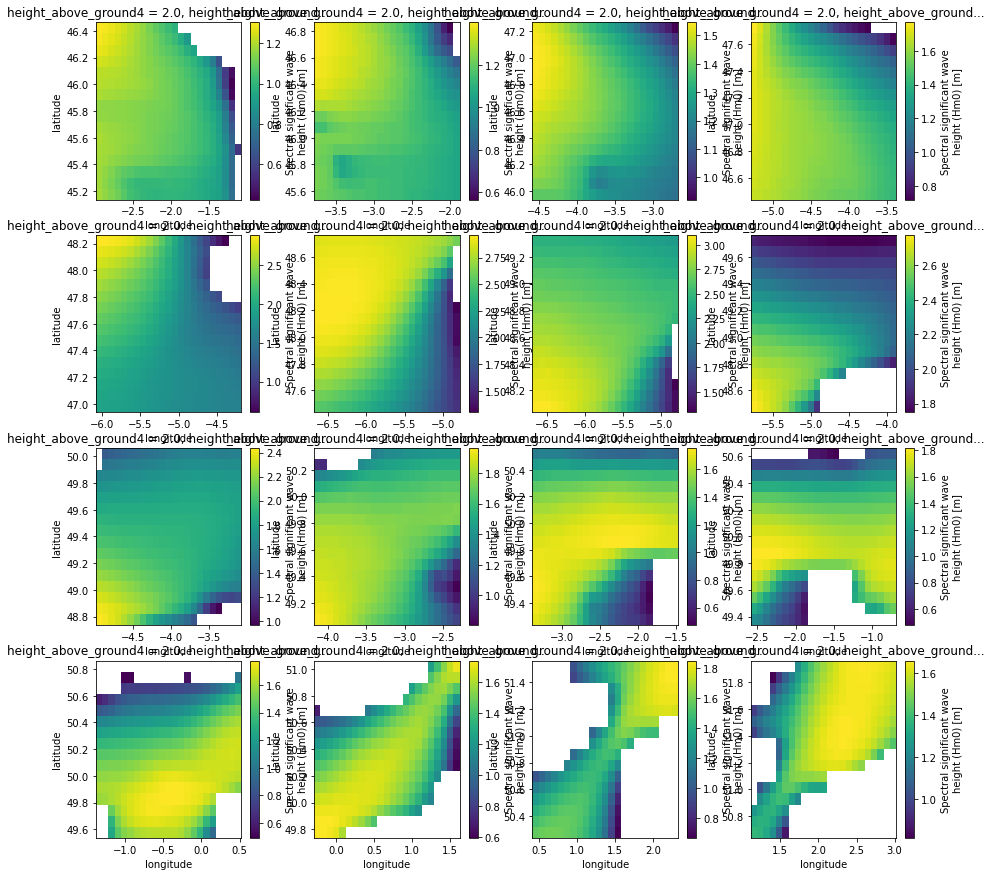

In [71]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(15,15))

col = 0
row = 0
for idx, dataset in enumerate(datasets):
    idx = idx + 1
    #print(idx, row, col)
    dataset.isel(time=0).VHM0.plot(ax=axes[row, col])
    #dataset.isel(time=0).VHM0.plot(ax=axes[row, col], vmin=1.2, vmax=2.7)
    if idx % 4 == 0:
        row = row + 1
        col = 0
    else:
        col = col + 1

---

## 7) Space time worm with netCDF groups

xarray does not support a data structure with multiple groups. A Dataset corrsponds to a single group in a netCDF file.
http://xarray.pydata.org/en/stable/user-guide/io.html#groups

### 7.1) Save data

In [72]:
#save_with_groups(datasets, NC_FILE_GROUPS)

'/home/martin/Projekte/MariData/software/space_time_worm/cmems_cube_60km_groups.nc'

### 7.2) Load data

In [73]:
datasets_group = []
for idx in range(1,17):
    datasets_group.append(xr.load_dataset(NC_FILE_GROUPS, group='point_{:02d}'.format(idx)))
#datasets_group

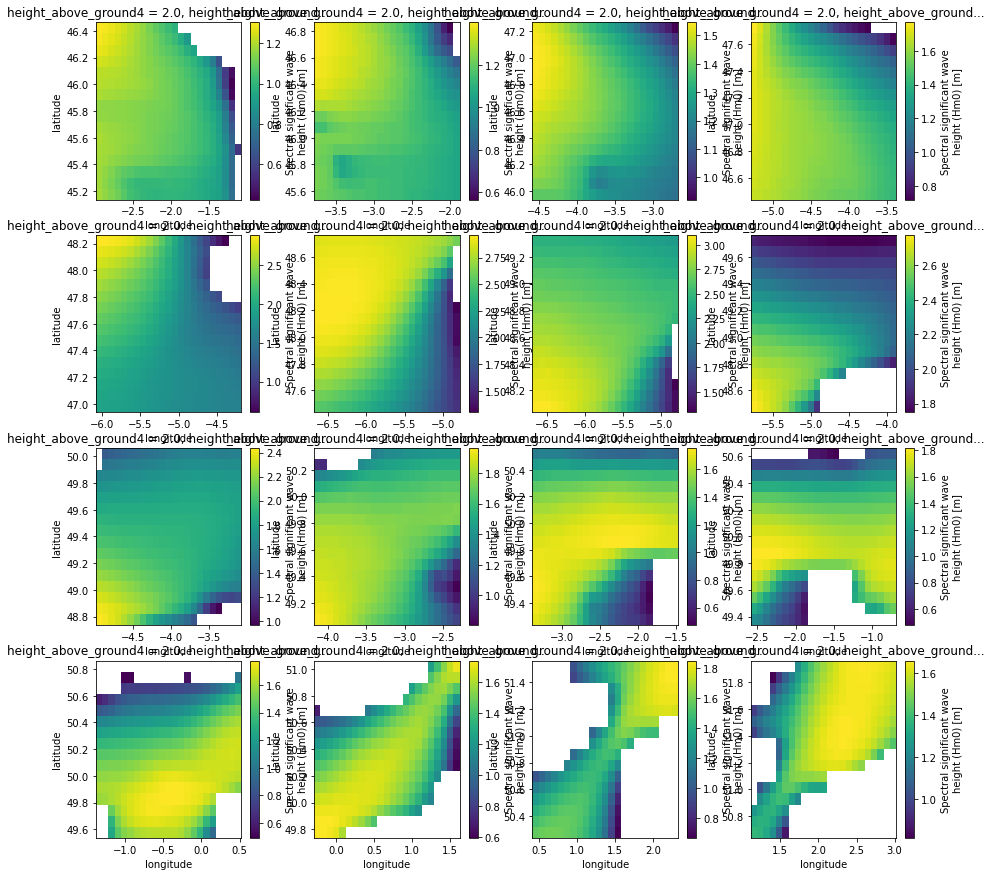

In [74]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(15,15))

col = 0
row = 0
for idx, dataset in enumerate(datasets_group):
    idx = idx + 1
    #print(idx, row, col)
    dataset.isel(time=0).VHM0.plot(ax=axes[row, col])
    #dataset.isel(time=0).VHM0.plot(ax=axes[row, col], vmin=1.2, vmax=2.7)
    if idx % 4 == 0:
        row = row + 1
        col = 0
    else:
        col = col + 1

---

## 8) Space time worm with relative coordinates (single grid)

Challenges:
* How to make sure all relative grids are identical?

### 8.1) Transform grids

In [75]:
datasets_rel_coords = []
# Make sure order of datasets and points is correct
for idx, dataset in enumerate(datasets):
    datasets_rel_coords.append(transform_coordinates(dataset.copy(), points[idx]))
#datasets_rel_coords

In [76]:
# For debug
#for dataset in datasets_rel_coords:
    #print(dataset.longitude.values)
    #print(dataset.longitude.values.tolist()) # for full precision
    #print(dataset.latitude.values)
    #print(dataset.latitude.values.tolist()) # for full precision
    #print(dataset.time.values)
    #print(list(dataset.data_vars))

### 8.2) Combine datasets

In [77]:
combined = xr.concat(datasets_rel_coords, dim='time', coords='minimal')
# "(attribute) must be a number, a string, an ndarray or a list/tuple of numbers/strings for serialization to netCDF files"
#combined.attrs['grid_shift'] = dict(zip(combined.time.values.astype(str).tolist(), points))
combined = combined.assign_coords(route_lon=[point[0] for point in points])
combined = combined.assign_coords(route_lat=[point[1] for point in points])
combined

<xarray.Dataset>
Dimensions:                           (latitude: 16, longitude: 23, route_lat: 16, route_lon: 16, time: 16)
Coordinates:
    height_above_ground4              float64 2.0
    height_above_ground_layer1        float64 3e+03
  * latitude                          (latitude) float64 -0.6226 ... 0.6224
  * longitude                         (longitude) float64 -0.946 -0.863 ... 0.88
  * time                              (time) datetime64[ns] 2021-04-02 ... 20...
    depth                             float32 0.494
  * route_lon                         (route_lon) float64 -2.0 -2.8 ... 1.4 2.1
  * route_lat                         (route_lat) float64 45.8 46.2 ... 51.3
Data variables:
    VHM0                              (time, latitude, longitude) float64 1.1...
    VPED                              (time, latitude, longitude) float64 292...
    VTPK                              (time, latitude, longitude) float64 11....
    so                                (time, latitude, longitude) float64 35....
    uo                                (time, latitude, longitude) float64 0.0...
    vo                                (time, latitude, longitude) float64 -0....
    u-component_of_wind_maximum_wind  (time, latitude, longitude) float64 -13...
    v-component_of_wind_maximum_wind  (time, latitude, longitude) float64 9.9...
    Temperature_surface               (time, latitude, longitude) float64 285...
Attributes:
    timeRange:     Time range: 2021-04-01 21:00:00 to 2021-04-02 03:00:00
    lon_extent:    Longitude extent: -2.95 to -1.05
    lat_extent:    Latitude extent: 45.18 to 46.42
    spatial_res:   Spatial Resolution 0.083deg x 0.083deg
    temporal_res:  Temporal Resolution 3-hours interval
    credit_CMEMS:  Credit (Wave-Wind-Physical): E.U. Copernicus Marine Servic...
    credit_GFS:    Credit (GFS): National Centers for Environmental Predictio...
    created:       Accessed on 2022-01-20 15:45:56
    errors:        Error(s):

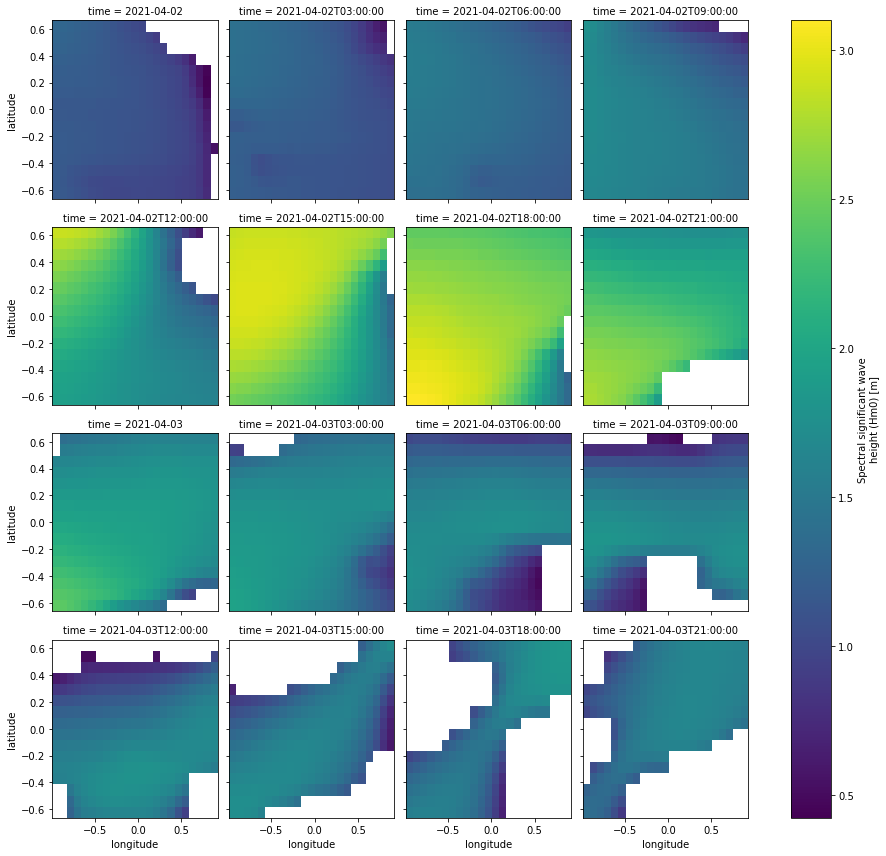

In [78]:
combined.VHM0.plot(x="longitude", y="latitude", col="time", col_wrap=4);

In [79]:
combined.to_netcdf(NC_FILE_REL_COORDS)

---

## 9) Memory comparison

In [80]:
memory_groups = os.stat(NC_FILE_GROUPS).st_size
memory_rel_coords = os.stat(NC_FILE_REL_COORDS).st_size
print('Group approach:', memory_groups / 1000, 'kB')
print('Relative coordinates approach:', memory_rel_coords / 1000, 'kB')

Group approach: 1193.073 kB
Relative coordinates approach: 476.808 kB


In [81]:
total_bbox = [np.min([p[0] for p in points]), 
              np.min([p[1] for p in points]),
              np.max([p[0] for p in points]),
              np.max([p[1] for p in points])]
total_bbox

[-5.7, 45.8, 2.1, 51.3]

In [82]:
resx = resy = 0.083 # in deg
memory_per_pixel = 8 # bytes (float64)
num_vars = 9 # number of variables

In [83]:
nx = math.ceil((total_bbox[2]-total_bbox[0])/resx)
ny = math.ceil((total_bbox[3]-total_bbox[1])/resy)
print("nx = {}, ny = {}".format(nx, ny))

nx = 94, ny = 67


In [84]:
# ToDo: download from EnvDataAPI to verify
memory_total = nx * ny * len(times) * num_vars * memory_per_pixel + \
               nx * memory_per_pixel + ny * memory_per_pixel + len(times) * memory_per_pixel
print('Memory for total bbox:', memory_total / 1000, 'kB')

Memory for total bbox: 7256.712 kB
